# **1. 데이터 차원**
- 데이터 자체는 충분함
- 불균형 데이터 -> Data Augmentation
- 데이터 범위(scale) 조정: 정규화/규제화/표준화

# **2. 알고리즘 차원**
- 학습률(learning rate)
    - Learning rate Scheduler 활용
- 활성화 함수/손실함수
    - 활성화 함수: softmax
    - 손실 함수: CrossEntropyLoss
- 배치/ Epoch
    - batch size: 256
    - Epoch: 100
    - EarlyStopping 적용
      - 사용자 정의 모듈
      - https://github.com/Bjarten/early-stopping-pytorch

# **3. 하드웨어 차원**
- gpu 활용

In [1]:
### 필요한 라이브러리 준비

import torch
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import cv2
import copy
import argparse

from torch import nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models
from ipywidgets import interact
from module.pytorchtools import EarlyStopping # 사용자 정의 모듈
                                              # 외부 py파일을 모듈로 import하여 EarlyStopping 함수 사용

In [2]:
### gpu 장치 확인
print(torch.__version__) 
print(torch.cuda.get_device_name(0))

1.12.1+cu116
NVIDIA GeForce GTX 1660 SUPER


### **DataLoader**

In [3]:
train_data_dir = './DataSet/archive/train/'
train_data_df = pd.read_csv(os.path.join(train_data_dir,'train.csv'))

# 분류에 사용할 class 정의(7개의 감정들)
feelings_list = ['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']

In [4]:
IMAGE_SIZE = 48

### 이미지 파일 경로를 리스트 형태로 저장하기 위한 함수
def list_image_file(data_dir,sub_dir):
    image_files = []
    
    images_dir = os.path.join(data_dir,sub_dir)
    for file_path in os.listdir(images_dir):
        image_files.append(os.path.join(sub_dir,file_path))
    return image_files

In [5]:
### 학습 데이터셋 클래스

class Feeling_dataset(Dataset):
    ### 생성자
    def __init__(self,data_dir,transform = None):
        self.data_dir = data_dir # 데이터가 저장된 상위 directory
        angry_imgs = list_image_file(data_dir,'angry')
        disgust_imgs = list_image_file(data_dir,'disgust')
        fear_imgs = list_image_file(data_dir,'fear')
        happy_imgs = list_image_file(data_dir,'happy')
        neutral_imgs = list_image_file(data_dir,'neutral')
        sad_imgs = list_image_file(data_dir,'sad')
        surprise_imgs = list_image_file(data_dir,'surprise')
        
        # 모든 사진들의 경로를 하나의 리스트에 저장
        self.files_path = angry_imgs + disgust_imgs + fear_imgs + happy_imgs + neutral_imgs + sad_imgs + surprise_imgs
        self.transform = transform
    
    ### 데이터 개수 확인
    def __len__(self):
        return len(self.files_path) # 전체 데이터 개수
    
    ### getitem
    def __getitem__(self,index):
        # image(feature data)
        image_file = os.path.join(self.data_dir,self.files_path[index])
        image = cv2.imread(image_file)
        image = cv2.resize(image,dsize = (IMAGE_SIZE,IMAGE_SIZE),interpolation = cv2.INTER_LINEAR)
        image = cv2.cvtColor(image,cv2.COLOR_BGR2RGB)
        
        # feeling(target data)
        target = feelings_list.index(self.files_path[index].split(os.sep)[0])
        
        if self.transform:
            image = self.transform(image) # feature data에 대해서만 데이터 변형 수행
            target = torch.Tensor([target]).long()
            
        return {'image':image,'target':target}

In [6]:
### Transformation

# 학습 feature data 변환
train_transformer = transforms.Compose([
    transforms.ToPILImage(),
    transforms.RandomHorizontalFlip(), # 수평으로 뒤집기
    transforms.RandomVerticalFlip(), # 수직으로 뒤집기
    transforms.ToTensor(), # 텐서로 변환
    transforms.Normalize(mean = [0.485, 0.456, 0.406], std = [0.229, 0.224, 0.225]) # 정규화
])

# 검증 feature data 변환
val_transformer = transforms.Compose([
    transforms.ToTensor(), # 텐서로 변환
    transforms.Normalize(mean = [0.485, 0.456, 0.406], std = [0.229, 0.224, 0.225]) # 정규화
])

In [7]:
### 데이터로더 구현
def build_dataloader(train_data_dir,val_data_dir):
    dataloaders = {}
    train_dset = Feeling_dataset(train_data_dir,train_transformer)
    dataloaders['train'] = DataLoader(train_dset,batch_size = 64,shuffle = True,drop_last = True)
    
    val_dset = Feeling_dataset(val_data_dir,val_transformer)
    dataloaders['val'] = DataLoader(val_dset,batch_size = 64,shuffle = False,drop_last = False)
    
    return dataloaders

In [8]:
train_data_dir = './DataSet/archive/train/'
val_data_dir = train_data_dir = './DataSet/archive/valid/'
dataloaders = build_dataloader(train_data_dir,val_data_dir)

### **Modeling**

In [9]:
from torchsummary import summary

In [10]:
### 모델 생성 함수
# 기존의 ResNet50 모델 호출 -> head 부분 수정
def build_resnet50_based_model():
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    
    model = models.resnet50(pretrained = True) # 이미 학습된 resnet50 모델 불러오기
    
    # 일반 NN layer(FC layer)
    model.avgpool = nn.AdaptiveAvgPool2d(output_size = (1,1))
    model.fc = nn.Linear(2048,7) # 7개의 감정으로 분류
    
    return model.to(device)

### **Estimation**

In [11]:
### 모델 검증을 위한 accuracy

@torch.no_grad() 
def get_accuracy(image,target,model):
    batch_size = image.shape[0] 
    prediction = model(image) # 예측 
    _,pred_label = torch.max(prediction,dim = 1) # 예측이 어느 클래스에 속하는지 확률이 가장 높은 1개 선택
    is_correct = (pred_label == target)
    
    return is_correct.cpu().numpy().sum() / batch_size

### **Training**

In [12]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

### Epoch을 1번 수행
def train_one_epoch(dataloaders,model,optimizer,loss_func,device):
    losses = {} # loss값 저장
    accuracies = {} # 정확도 값 저장
    
    for tv in ['train','val']:
        ### loss, accuracy를 계속 갱신
        running_loss = 0.0
        running_correct = 0
        
        if tv == 'train': # 학습
            model.train()
        else: # 검증
            model.eval()
        
        for index,batch in enumerate(dataloaders[tv]):
            image = batch['image'].to(device) # feature data(이미지)
            target = batch['target'].squeeze(dim = 1).to(device) # label data(감정), 1차원으로 차원 축소 진행
            
            ### 역전파 적용
            with torch.set_grad_enabled(tv == 'train'): 
                prediction = model(image) # label 예측
                loss = loss_func(prediction,target) # loss값 계산
                
                if tv == 'train':
                    optimizer.zero_grad() # 한 번의 학습 완료 -> gradient를 0으로 초기화
                    loss.backward() # 역전파
                    optimizer.step() # 가중치 업데이트
                    
            running_loss += loss.item()
            running_correct += get_accuracy(image,target,model)
            
            if tv == 'train':
                if index % 50 == 0:
                    print(f"{index}/{len(dataloaders['train'])} - Running loss: {loss.item()}")
        losses[tv] = running_loss / len(dataloaders[tv])
        accuracies[tv] = running_correct / len(dataloaders[tv])
    return losses, accuracies

In [13]:
### 학습이 잘 된 모델 저장
def save_best_model(model_state,model_name,save_dir = './best_model'):
    os.makedirs(save_dir,exist_ok = True) # 경로 존재 시 덮어쓰기, 없는 경우 새로 생성
    torch.save(model_state,os.path.join(save_dir,model_name)) # 모델 저장

In [14]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

### 경로 설정
train_data_dir = './DataSet/archive/train/'
val_data_dir = './DataSet/archive/valid/'

### 필요한 요소들 준비
dataloaders = build_dataloader(train_data_dir,val_data_dir)
model = build_resnet50_based_model()
loss_func = nn.CrossEntropyLoss(reduction = 'mean')
optimizer = torch.optim.Adam(model.parameters(),lr = 1e-3)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode = 'min', patience = 3, factor = 0.1,
                                                       min_lr = 1e-13,verbose = True)  # lr scheduling
early_stopping = EarlyStopping(patience = 20, verbose = False) # 조기 종료(사용자 정의 모듈)

c:\users\bin\appdata\local\programs\python\python38\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
c:\users\bin\appdata\local\programs\python\python38\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [15]:
num_epochs = 100

best_acc = 0.0
train_loss,train_accuracy = [],[]
val_loss,val_accuracy = [],[]

for epoch in range(num_epochs):
    ### 1 Epoch 수행
    losses, accuracies = train_one_epoch(dataloaders, model, optimizer, loss_func, device)
    
    ### LR Scheduling
    scheduler.step(losses['val']) # 1 Epoch 수행 후 learning rate 조정
    # EarlyStopping
    early_stopping(losses['val'], model) # 현재 과적합 상황 추적
    if early_stopping.early_stop: # 조건 만족 시 조기 종료
        break
        
    train_loss.append(losses['train'])
    val_loss.append(losses['val'])
    train_accuracy.append(accuracies['train'])
    val_accuracy.append(accuracies['val'])
    
    print(f"{epoch+1}/{num_epochs}-Train Loss:{losses['train']}, Val Loss:{losses['val']}")
    print(f"{epoch+1}/{num_epochs}-Train Acc:{accuracies['train']}, Val Acc:{accuracies['val']}")
    
    # deepcopy: 배열의 내부 객체까지 복사를 해서 사용
    # copy: 배열의 내부 객체까지 깊은 복사를 해주지 않음
    if (epoch > 3) and (accuracies['val'] > best_acc):
        best_acc = accuracies['val']
        best_model = copy.deepcopy(model.state_dict()) 
        save_best_model(best_model, f'model_{epoch+1:02d}.pth')

print(f'Best Accuracy: {best_acc}')

0/455 - Running loss: 2.111924409866333
50/455 - Running loss: 1.3625683784484863
100/455 - Running loss: 1.5211122035980225
150/455 - Running loss: 1.388885498046875
200/455 - Running loss: 1.426329255104065
250/455 - Running loss: 1.3842612504959106
300/455 - Running loss: 1.5243439674377441
350/455 - Running loss: 1.5369011163711548
400/455 - Running loss: 1.1582850217819214
450/455 - Running loss: 1.3227967023849487
1/100-Train Loss:1.5210997028665227, Val Loss:3.7116968380777458
1/100-Train Acc:0.4830357142857143, Val Acc:0.3513418079096045
0/455 - Running loss: 1.3151123523712158
50/455 - Running loss: 1.3965805768966675
100/455 - Running loss: 1.5538556575775146
150/455 - Running loss: 1.3054697513580322
200/455 - Running loss: 1.3145264387130737
250/455 - Running loss: 1.102340817451477
300/455 - Running loss: 1.1971303224563599
350/455 - Running loss: 1.145903468132019
400/455 - Running loss: 1.3950936794281006
450/455 - Running loss: 1.1282509565353394
2/100-Train Loss:1.3263

350/455 - Running loss: 1.1374937295913696
400/455 - Running loss: 0.966640055179596
450/455 - Running loss: 0.6940770149230957
15/100-Train Loss:0.8727818177296565, Val Loss:1.057527810858007
15/100-Train Acc:0.7279532967032967, Val Acc:0.6080229705619982
0/455 - Running loss: 0.6193694472312927
50/455 - Running loss: 0.6772423982620239
100/455 - Running loss: 0.6073051691055298
150/455 - Running loss: 0.7769672870635986
200/455 - Running loss: 0.8293086290359497
250/455 - Running loss: 0.8509951233863831
300/455 - Running loss: 1.0153752565383911
350/455 - Running loss: 0.775720477104187
400/455 - Running loss: 1.0343034267425537
450/455 - Running loss: 0.7120264768600464
16/100-Train Loss:0.8497369378477663, Val Loss:1.0552809944278316
16/100-Train Acc:0.7368131868131869, Val Acc:0.6115168748141541
0/455 - Running loss: 0.7001448273658752
50/455 - Running loss: 0.8107082843780518
100/455 - Running loss: 0.8033923506736755
150/455 - Running loss: 0.6860846877098083
200/455 - Running 

300/455 - Running loss: 0.4188424050807953
350/455 - Running loss: 0.5613940954208374
400/455 - Running loss: 0.3107025921344757
450/455 - Running loss: 0.29860737919807434
EarlyStopping counter: 11 out of 20
29/100-Train Loss:0.3907635667821863, Val Loss:1.1503577467642332
29/100-Train Acc:0.8655563186813187, Val Acc:0.6412150609574784
0/455 - Running loss: 0.334323912858963
50/455 - Running loss: 0.4678158462047577
100/455 - Running loss: 0.4717400372028351
150/455 - Running loss: 0.5451269149780273
200/455 - Running loss: 0.4376479685306549
250/455 - Running loss: 0.34730371832847595
300/455 - Running loss: 0.29646480083465576
350/455 - Running loss: 0.37707972526550293
400/455 - Running loss: 0.39204150438308716
450/455 - Running loss: 0.38851094245910645
Epoch 00030: reducing learning rate of group 0 to 1.0000e-06.
EarlyStopping counter: 12 out of 20
30/100-Train Loss:0.3879265459029229, Val Loss:1.1539951108003919
30/100-Train Acc:0.8677541208791208, Val Acc:0.6417168450787987
0/

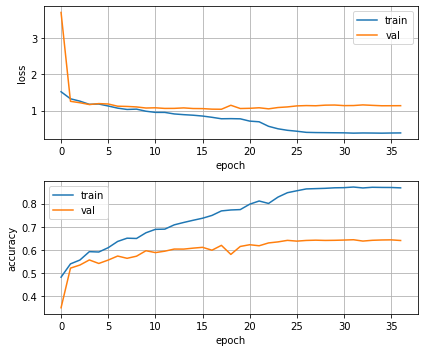

In [17]:
### Loss, Accuracy 시각화

plt.figure(figsize = (6,5))

# Loss
plt.subplot(211)
plt.plot(train_loss,label = "train")
plt.plot(val_loss,label = "val")
plt.xlabel("epoch")
plt.ylabel("loss")
plt.grid("on")
plt.legend()

# Accuracy
plt.subplot(212)
plt.plot(train_accuracy,label = "train")
plt.plot(val_accuracy,label = "val")
plt.xlabel("epoch")
plt.ylabel("accuracy")
plt.grid("on")
plt.legend()

plt.tight_layout()